### A Load images

Image size:  40000
Image shape:  (200, 200)
Before rescaling:
Image 0: min=0, max=255
Image 1: min=1, max=255


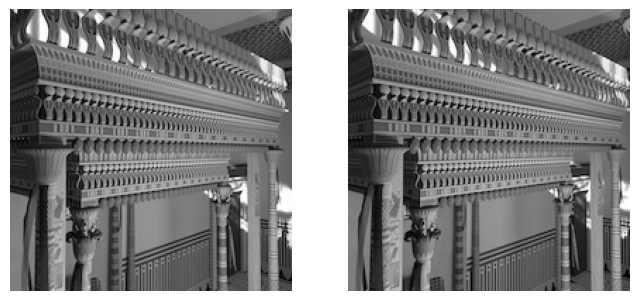

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np  
import os

def compute_cor(S1, S2):
    N = S1.size
    cor = 0
    for i in range(S1.shape[0]):
        for j in range(S1.shape[1]):
            cor += S1[i, j] * S2[i, j]
    cor /= N
    return cor

figures_dir  = os.path.join(".", "figures")

image_L = Image.open(os.path.join(figures_dir, "Vue5L.jpg")).convert('L')  # 'L' means the gray scale
image_R = Image.open(os.path.join(figures_dir, "Vue5R.jpg")).convert('L')

# image_L = Image.open(os.path.join(figures_dir, "imageL.png")).convert('L')  # 'L' means the gray scale
# image_R = Image.open(os.path.join(figures_dir, "imageR.png")).convert('L')

# image_L = Image.open(os.path.join(figures_dir, "1-webL.jpg")).convert('L')  # 'L' means the gray scale
# image_R = Image.open(os.path.join(figures_dir, "1-webR.jpg")).convert('L')

images = [np.array(image_L), np.array(image_R)] # convert the image to a 2D numpy array

size = images[0].size  # both images have the same size
print("Image size: ", size)
print("Image shape: ", images[0].shape)

print("Before rescaling:")
for i, image in enumerate(images):
    print(f"Image {i}: min={np.min(image)}, max={np.max(image)}")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

im0 = axes[0].imshow(images[0], cmap='gray')
im1 = axes[1].imshow(images[1], cmap='gray')
axes[0].axis('off')
axes[1].axis('off')
# fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
# fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

# plt.imshow(image_L, cmap='gray')  # show the image
# plt.axis('off')     # turn down the axis
# plt.savefig(os.path.join(figures_dir, "images_luminance.png"),             
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()



### B Normalize the image

In [2]:
S_top = 255

for i, image in enumerate(images):
    max_val = np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val) * S_top
    image = image.astype(np.int16)
    images[i] = image  # Update the rescaled image

print("After rescaling:")
for i, image in enumerate(images):
    print(f"Image {i}: min={np.min(image)}, max={np.max(image)}")

After rescaling:
Image 0: min=0, max=255
Image 1: min=0, max=255


### C Probability $P(S)$

256 256
255 255


(0.0, 255.0)

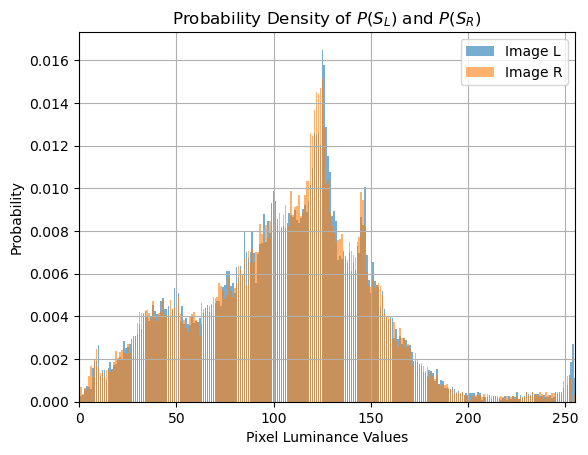

In [3]:
prob_values = []

for i ,image in enumerate(images):
    values, counts = np.unique(image, return_counts=True)
    sorted_indices = np.argsort(values)  # sorting by values
    values = values[sorted_indices]
    counts = counts[sorted_indices]
    # turn into probability distribution
    props = counts / np.sum(counts)
    print(len(values), len(props))
    prob_values.append((values, props))
    plt.bar(values, props, label=f'Image {"L" if i==0 else "R"}', alpha=0.6)
plt.xlabel('Pixel Luminance Values')
plt.ylabel('Probability')
plt.title('Probability Density of $P(S_L)$ and $P(S_R)$')
plt.legend()
plt.grid()
plt.xlim(0, S_top)
# plt.savefig(os.path.join(figures_dir, "prob_LR.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )

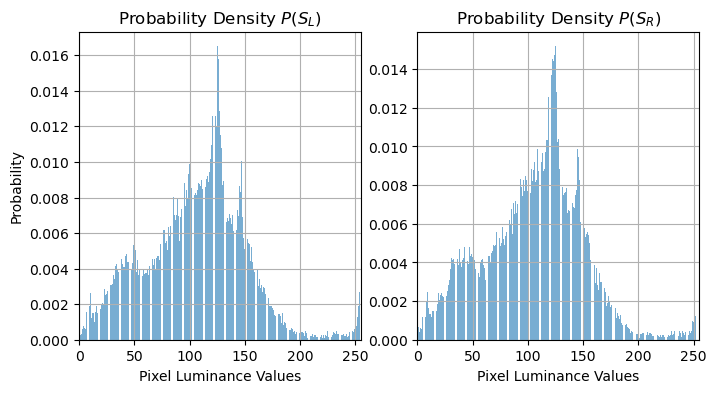

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列
for i ,probs in enumerate(prob_values):
    values, props = probs
    axes[i].bar(values, props, label=f'Image {"L" if i==0 else "R"}', alpha=0.6)
    axes[i].set_xlabel('Pixel Luminance Values')
    if i==0:
        axes[i].set_ylabel('Probability')
    axes[i].set_title(f'Probability Density $P(S_{{{"L" if i==0 else "R"}}})$')
    # axes[i].legend()
    axes[i].grid()
    axes[i].set_xlim(0, S_top)
    
# plt.savefig(os.path.join(figures_dir, f"prob_L_R.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )


### D Pixel Entropy

In [5]:
entropy_values = []
for i, image in enumerate(images):
    values, props = prob_values[i]
    entropy = -np.sum(props * np.log2(props + 1e-10))  # add a small value to avoid log(0)
    entropy_values.append(entropy)
    print(f'Entropy of Image {"L" if i==0 else "R"}: {entropy:.4f} bits')


Entropy of Image L: 7.4300 bits
Entropy of Image R: 7.4194 bits


### E Joint Prob

Total probability (should be 1.0): 1.0


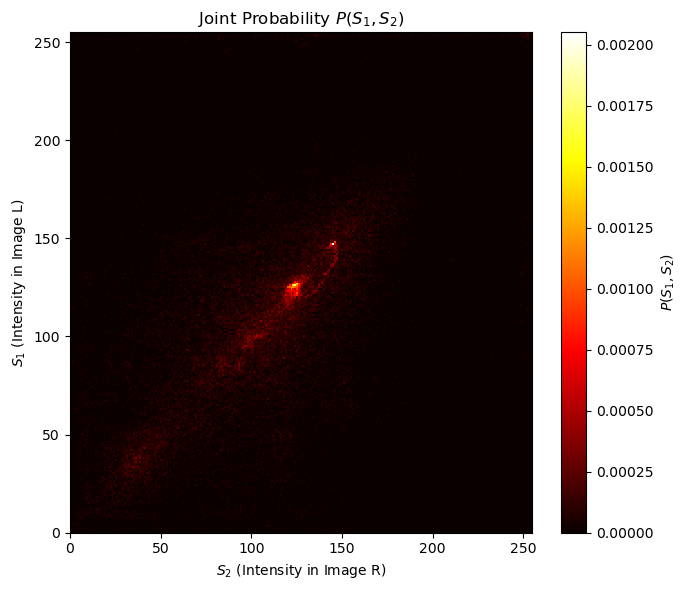

In [6]:
# Compute true joint distribution P(S1, S2) from paired pixels (SL(x,y), SR(x,y))

flatL = images[0].ravel()
flatR = images[1].ravel()
N = flatL.size

S_max = S_top  # 255

joint_counts = np.zeros((S_max + 1, S_max + 1), dtype=np.int64)
np.add.at(joint_counts, (flatL, flatR), 1)  # accumulate counts for each (S1,S2)  AMAZING!!!

joint_probs = joint_counts / N  # P(S1,S2) = n(S1,S2) / N

# quick sanity check
print("Total probability (should be 1.0):", joint_probs.sum())

# Plot joint probability as a heatmap
plt.figure(figsize=(7, 6))
plt.imshow(joint_probs, origin='lower', cmap='hot', 
           interpolation='nearest',
           extent=[0, S_max, 0, S_max], aspect='auto',
        #    vmin=-0.0001,
           vmax=joint_probs.max())
# plt.ylim(0, S_max)
plt.colorbar(label='$P(S_1, S_2)$')
plt.xlabel('$S_2$ (Intensity in Image R)')
plt.ylabel('$S_1$ (Intensity in Image L)')
plt.title('Joint Probability $P(S_1, S_2)$')
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, f"joint_prob_LR.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

### F Joint Entropy $H(S_1, S_2)$

In [7]:
# joint_entropy = 0
# for joint_p in joint_probs.flatten():
#     assert joint_p >= 0, "Joint probability is negative"
#     log_value = np.log2(joint_p) if joint_p > 0 else 0
#     joint_entropy += -joint_p * log_value
joint_entropy = np.sum(-joint_probs * np.log2(joint_probs + 1e-10)) # add a small value to avoid log(0)
print(f'Joint Entropy H(S1, S2): {joint_entropy:.4f} bits')

Joint Entropy H(S1, S2): 13.5912 bits


### G Mutual Information $I(S_1; S_2)$

In [8]:
mutual_information = entropy_values[0] + entropy_values[1] - joint_entropy
print(f'Mutual Information I(S1; S2): {mutual_information:.4f} bits')

Mutual Information I(S1; S2): 1.2582 bits


### H Redundancy

In [9]:
redundancy = (entropy_values[0] + entropy_values[1]) / joint_entropy - 1
print(f'Redundancy R: {redundancy:.4f} bits')

Redundancy R: 0.0926 bits


### I Repeat for different `S_top`= $2^n-1, n=1,...,8$

Testing with S_top = 1
Testing with S_top = 3
Testing with S_top = 7
Testing with S_top = 15
Testing with S_top = 31
Testing with S_top = 63
Testing with S_top = 127
Testing with S_top = 255


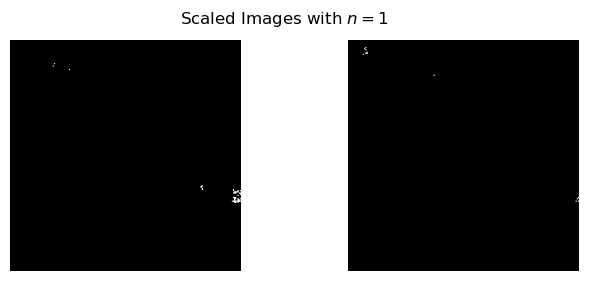

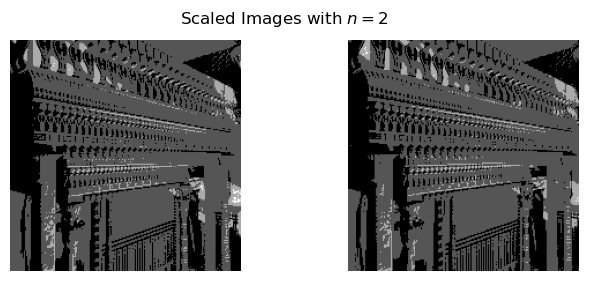

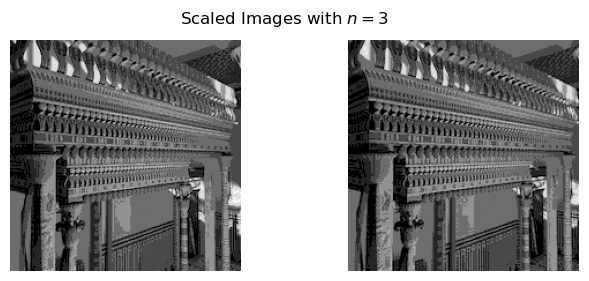

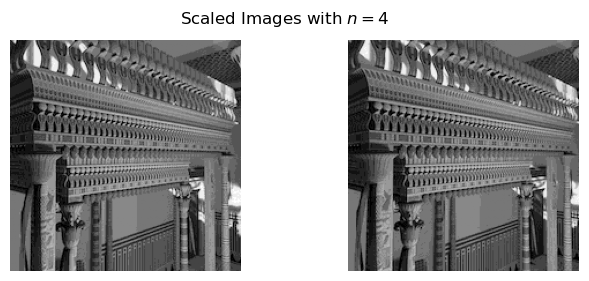

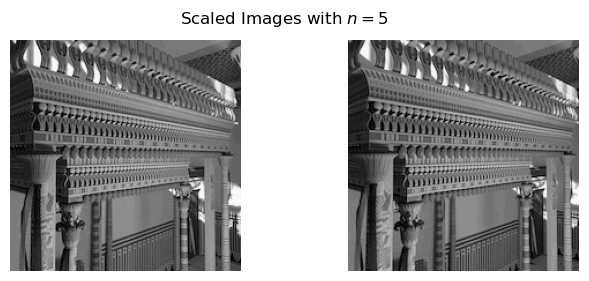

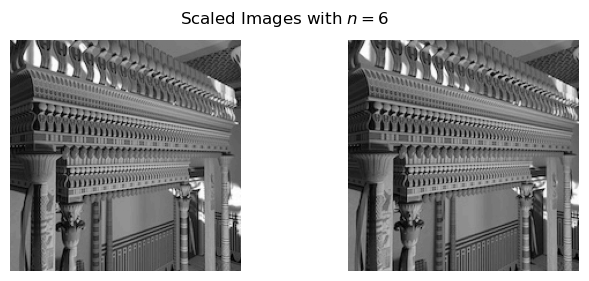

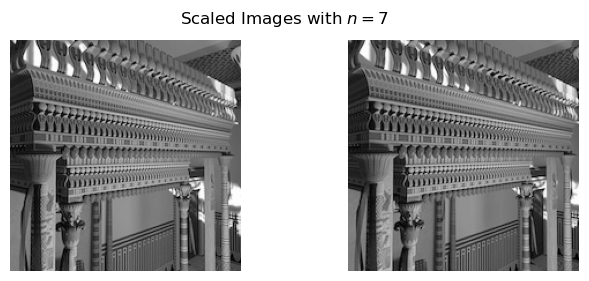

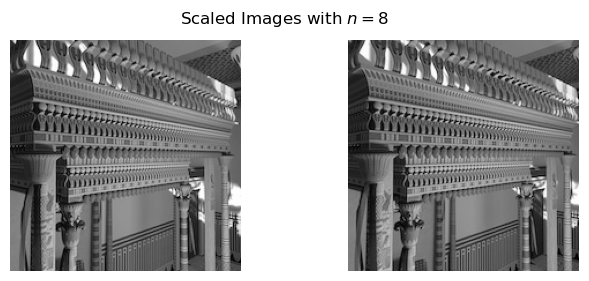

In [25]:
n_list = list(range(1, 9)) # n = 1,...,8
S_top_list = [2**n-1 for n in n_list]  # 1, 3, 7, 15, 31, 63, 127, 255

entropy_1_list = []
entropy_2_list = []
joint_entropy_list = []
mutual_info_list = []
redundancy_list = []

prob_list = []
joint_prob_list = []

for S_top, n in zip(S_top_list, n_list):
    print(f"Testing with S_top = {S_top}")

    # normalize with S_top
    scaled_images = []
    for i, image in enumerate(images):
        max_val = np.max(image)
        min_val = np.min(image)
        image = (image - min_val) / (max_val - min_val) * S_top
        image = image.astype(np.uint8)
        scaled_images.append(image)
        
    # Plot the scaled images
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 一行两列
    axes[0].imshow(scaled_images[0], cmap='gray')
    axes[1].imshow(scaled_images[1], cmap='gray')
    axes[0].axis('off')
    axes[1].axis('off')
    plt.suptitle(f'Scaled Images with $n={n}$')
    # plt.savefig(os.path.join(figures_dir, f"images_luminance_n{n}.png"),             
    #     bbox_inches='tight',  # 紧贴内容裁剪
    #     pad_inches=0.1,         # 去掉额外留白
    #     )

    # prop
    prob_values = []
    for i ,image in enumerate(scaled_images):
        values, counts = np.unique(image, return_counts=True)
        sorted_indices = np.argsort(values)  # sorting by values
        values = values[sorted_indices]
        counts = counts[sorted_indices]
        # turn into probability distribution
        props = counts / np.sum(counts)
        prob_values.append((values, props))
    
    # entropy
    entropies = []
    for i, (values, props) in enumerate(prob_values):
        entropy = -np.sum(props * np.log2(props))
        entropies.append(entropy)
    
    # joint prob
    flatL = scaled_images[0].ravel()
    flatR = scaled_images[1].ravel()
    joint_counts = np.zeros((S_top + 1, S_top + 1), dtype=np.int64)
    np.add.at(joint_counts, (flatL, flatR), 1)
    joint_probs = joint_counts / flatL.size  # P(S1,S2) = n(S1,S2) / N

    # joint entropy
    joint_entropy = np.sum(-joint_probs * np.log2(joint_probs + 1e-10))  # avoid log(0)

    # mutual information
    mutual_information = entropies[0] + entropies[1] - joint_entropy
    
    # redundancy
    redundancy = (entropies[0] + entropies[1]) / joint_entropy - 1

    # store results
    entropy_1_list.append(entropies[0])
    entropy_2_list.append(entropies[1])
    joint_entropy_list.append(joint_entropy)
    mutual_info_list.append(mutual_information)
    redundancy_list.append(redundancy)

    prob_list.append(prob_values)
    joint_prob_list.append(joint_probs)

In [34]:
values, props = prob_values[0]
props.shape

(64,)

test

i=0
i=1


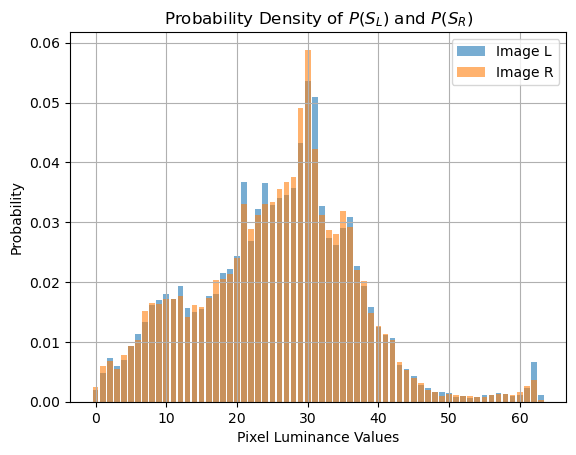

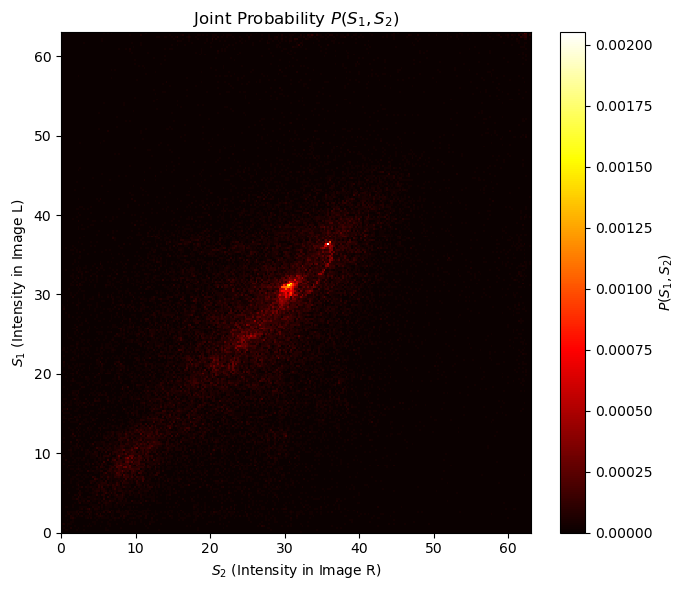

In [ ]:
# # test
# n = 5
# S_max = S_top_list[n]
# prob_values = prob_list[n]

# for i, (values, props) in enumerate(prob_values):
#     plt.bar(values, props, label=f'Image {"L" if i==0 else "R"}', alpha=0.6)
#     print(f"i={i}")

# plt.xlabel('Pixel Luminance Values')
# plt.ylabel('Probability')
# plt.title('Probability Density of $P(S_L)$ and $P(S_R)$')
# plt.legend()
# plt.grid()

# joint_prob = joint_prob_list[n]

# plt.figure(figsize=(7, 6))
# plt.imshow(joint_probs, origin='lower', cmap='hot', 
#            interpolation='nearest',
#            extent=[0, S_max, 0, S_max], aspect='auto',
#         #    vmin=-0.0001,
#            vmax=joint_probs.max())
# # plt.ylim(0, S_max)
# plt.colorbar(label='$P(S_1, S_2)$')
# plt.xlabel('$S_2$ (Intensity in Image R)')
# plt.ylabel('$S_1$ (Intensity in Image L)')
# plt.title('Joint Probability $P(S_1, S_2)$')
# plt.tight_layout()
# # plt.savefig(os.path.join(figures_dir, f"joint_prob_LR.pdf"),
# #             bbox_inches='tight',  # 紧贴内容裁剪
# #             pad_inches=0.1,         # 去掉额外留白
# #             )
# plt.show()

i=0
i=1


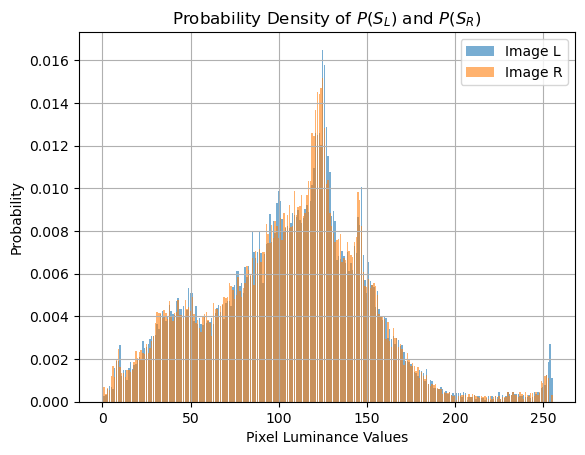

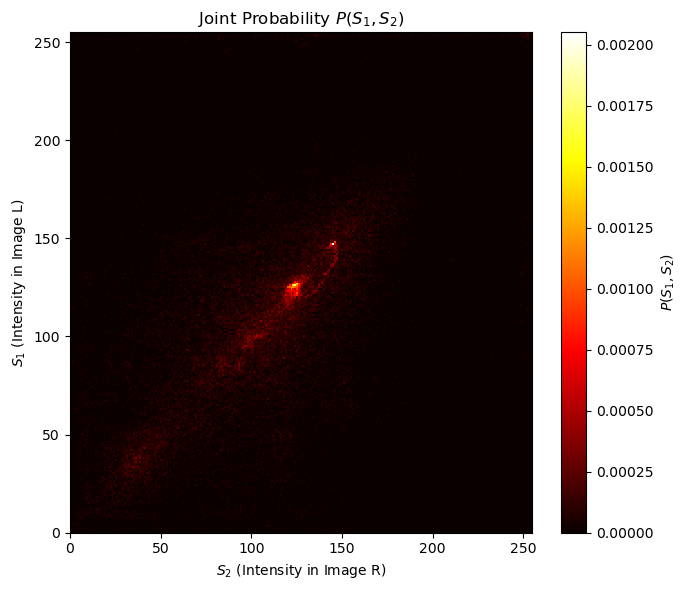

In [ ]:
# # test
# n = 7
# S_max = S_top_list[n]
# prob_values = prob_list[n]

# for i, (values, props) in enumerate(prob_values):
#     plt.bar(values, props, label=f'Image {"L" if i==0 else "R"}', alpha=0.6)
#     print(f"i={i}")

# plt.xlabel('Pixel Luminance Values')
# plt.ylabel('Probability')
# plt.title('Probability Density of $P(S_L)$ and $P(S_R)$')
# plt.legend()
# plt.grid()

# joint_prob = joint_prob_list[n]

# plt.figure(figsize=(7, 6))
# plt.imshow(joint_probs, origin='lower', cmap='hot', 
#            interpolation='nearest',
#            extent=[0, S_max, 0, S_max], aspect='auto',
#         #    vmin=-0.0001,
#            vmax=joint_probs.max())
# # plt.ylim(0, S_max)
# plt.colorbar(label='$P(S_1, S_2)$')
# plt.xlabel('$S_2$ (Intensity in Image R)')
# plt.ylabel('$S_1$ (Intensity in Image L)')
# plt.title('Joint Probability $P(S_1, S_2)$')
# plt.tight_layout()
# # plt.savefig(os.path.join(figures_dir, f"joint_prob_LR.pdf"),
# #             bbox_inches='tight',  # 紧贴内容裁剪
# #             pad_inches=0.1,         # 去掉额外留白
# #             )
# plt.show()

In [10]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_list, entropy_1_list, linestyle='--', marker='o', label='$H(S_1)$')
plt.plot(n_list, entropy_2_list, linestyle='--', marker='x', label='$H(S_2)$')
plt.plot(n_list, joint_entropy_list, linestyle='--', marker='^', label='$H(S_1, S_2)$')
plt.plot(n_list, mutual_info_list, linestyle='--', marker='s', label='$I(S_1; S_2)$')
# plt.plot(n_list, redundancy_list, marker='d', linestyle='--', label='$R(S_1; S_2)$', alpha=0.5)
plt.xlabel('Scale of the highest pixel value $n$', fontsize=14)
# plt.xscale('log', base=2)
plt.ylabel('Entropy or Information [Bits]', fontsize=14)
plt.title('$H(S_1), H(S_2), H(S_1; S_2), I(S_1; S_2)$ vs $n$', fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.xticks(n_list)

# plt.savefig(os.path.join(figures_dir, f"entropy_mutual_info_vs_n.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

NameError: name 'n_list' is not defined

<Figure size 1000x600 with 0 Axes>

In [70]:
print(entropy_1_list[5], entropy_1_list[7])
print(entropy_2_list[5], entropy_2_list[7])
print("H(S1; S2):")
print(joint_entropy_list[5], joint_entropy_list[7])
print("I(S1; S2):")
print(mutual_info_list[5], mutual_info_list[7])
print("R(S1; S2):")
print(redundancy_list[5], redundancy_list[7])

5.426414674598817 7.430023421523179
5.414476736261486 7.4193726038167895
H(S1; S2):
10.241234298370994 13.591216041728368
I(S1; S2):
0.5996571124893091 1.2581799836116012
R(S1; S2):
0.05855320706652445 0.092573025088313


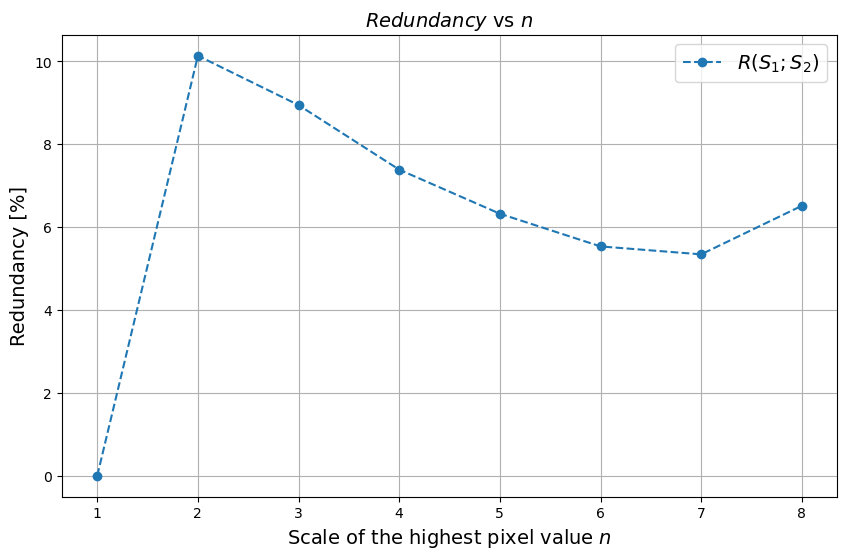

In [15]:
redundancy_rate_list = np.array(redundancy_list) * 100

plt.figure(figsize=(10, 6))
plt.plot(n_list, redundancy_rate_list, marker='o', linestyle='--', label='$R(S_1;S_2)$')
plt.ylabel('Redundancy [%]', fontsize=14)
plt.xlabel('Scale of the highest pixel value $n$', fontsize=14)
plt.title('$Redundancy$ vs $n$', fontsize=14)
plt.legend(fontsize=14)
plt.grid()

# plt.savefig(os.path.join(figures_dir, f"redundancy_vs_n.pdf"),
#     bbox_inches='tight',  # 紧贴内容裁剪
#     pad_inches=0.1,         # 去掉额外留白
#     )

### J Zero-mean and Correlation matrix

In [3]:
# Shift to zero-mean
zero_mean_images = [img - np.mean(img) for img in images]

print("Mean of original images:\n", [np.mean(img) for img in images])
print("Mean of zero-mean images:\n", [np.mean(img) for img in zero_mean_images])

# Compute correlation matrix, but not correlation coefficient

cor_matrix = np.zeros((2, 2))
cor_matrix[0, 0] = compute_cor(zero_mean_images[0], zero_mean_images[0])
cor_matrix[1, 1] = compute_cor(zero_mean_images[1], zero_mean_images[1])
cor_matrix[0, 1] = compute_cor(zero_mean_images[0], zero_mean_images[1])
cor_matrix[1, 0] = cor_matrix[0, 1]

print("Correlation matrix:\n", cor_matrix)


Mean of original images:
 [np.float64(105.93475), np.float64(105.459125)]
Mean of zero-mean images:
 [np.float64(2.1827872842550276e-15), np.float64(1.8189894035458565e-15)]
Correlation matrix:
 [[2057.29729244 1140.37073291]
 [1140.37073291 1990.28062923]]


### K Scatter plot

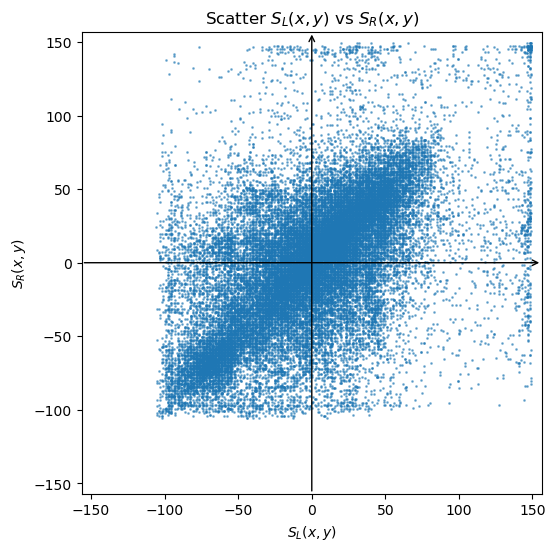

In [18]:
vals_L = zero_mean_images[0].ravel()
vals_R = zero_mean_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(vals_L, vals_R, alpha=0.5, s=1, rasterized=True)
plt.xlabel('$S_L(x,y)$')
plt.ylabel('$S_R(x,y)$')
plt.xlim(-max(vals_L)*1.05, max(vals_L)*1.05)
plt.ylim(-max(vals_R)*1.05, max(vals_R)*1.05)

plt.annotate('', xy=(max(vals_L)*1.05, 0), xytext=(-max(vals_L)*1.05, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(vals_R)*1.05), xytext=(0, -max(vals_R)*1.05),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.title('Scatter $S_L(x,y)$ vs $S_R(x,y)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(figures_dir, f"scatter_LR.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )

---

### L Eigenvalues and eigenvectors of $R^S$

In [15]:
eigen_vals, eigen_vecs = np.linalg.eig(cor_matrix)
# w: (1-D) array of eigenvalue
# v: (2-D) array of eigenvalue vector
print("Eigenvalues:\n", eigen_vals)
print("Eigenvectors:\n", eigen_vecs)

Eigenvalues:
 [3164.6518872   882.92603447]
Eigenvectors:
 [[ 0.71741586 -0.69664516]
 [ 0.69664516  0.71741586]]


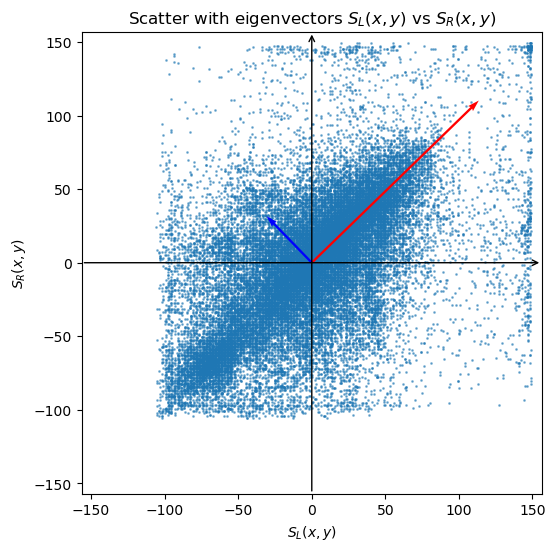

In [49]:
plt.figure(figsize=(7, 6))
plt.scatter(vals_L, vals_R, alpha=0.5, s=1, rasterized=True)
plt.xlabel('$S_L(x,y)$')
plt.ylabel('$S_R(x,y)$')
plt.xlim(-max(vals_L)*1.05, max(vals_L)*1.05)
plt.ylim(-max(vals_R)*1.05, max(vals_R)*1.05)


plt.annotate('', xy=(max(vals_L)*1.05, 0), xytext=(-max(vals_L)*1.05, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(vals_R)*1.05), xytext=(0, -max(vals_R)*1.05),
             arrowprops=dict(arrowstyle='->', color='k'))

# plot eigenvectors 
ox, oy = np.zeros(2), np.zeros(2)  # two arrow start positions at the origin
scale = eigen_vals / 20.0
U = eigen_vecs[0, :] * scale
V = eigen_vecs[1, :] * scale

plt.quiver(ox, oy, U, V, angles='xy', scale_units='xy', scale=1, color=['r', 'b'], width=0.005)

plt.gca().set_aspect('equal', adjustable='box')

plt.title('Scatter with eigenvectors $S_L(x,y)$ vs $S_R(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_LR_with_eigenvectors.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )

### M $\mathcal{S}_+(x,y)$ and $\mathcal{S}_-(x,y)$

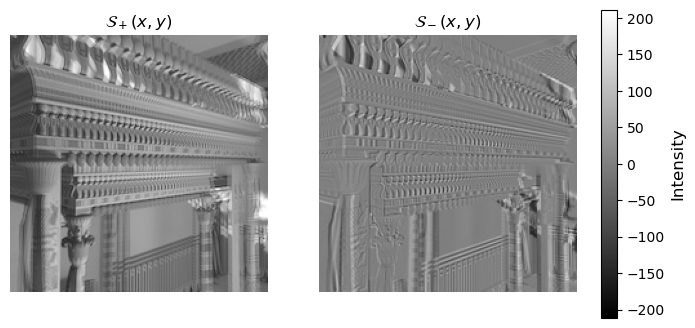

In [20]:
# Note that here we use the zero-mean images
image_plus = (zero_mean_images[0] + zero_mean_images[1])/np.sqrt(2)
image_minus = (-zero_mean_images[0] + zero_mean_images[1])/np.sqrt(2)
new_images = [image_plus, image_minus]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(new_images[0])), np.max(np.abs(new_images[1]))])
im0 = axes[0].imshow(new_images[0], cmap='gray', vmax=vmax, vmin=-vmax)
im1 = axes[1].imshow(new_images[1], cmap='gray', vmax=vmax, vmin=-vmax)
axes[0].axis('off')
axes[0].set_title('$\\mathcal{S}_+(x,y)$')
axes[1].set_title('$\\mathcal{S}_-(x,y)$')
axes[1].axis('off')

cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig(os.path.join(figures_dir, "images_LR_+-.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )
plt.show()

### N Correlation matrix and Scatter of $\mathcal{S}_+(x,y)$ and $\mathcal{S}_-(x,y)$

In [21]:
# Compute correlation matrix for new images
new_cor_matrix = np.zeros((2, 2))
new_cor_matrix[0, 0] = compute_cor(new_images[0], new_images[0])
new_cor_matrix[1, 1] = compute_cor(new_images[1], new_images[1])
new_cor_matrix[0, 1] = compute_cor(new_images[0], new_images[1])
new_cor_matrix[1, 0] = new_cor_matrix[0, 1]
new_cor_matrix

array([[3164.15969374,  -33.5083316 ],
       [ -33.5083316 ,  883.41822793]])

So $\text{Var}(S_+(x,y)) > \text{Var}(S_-(x,y))$.

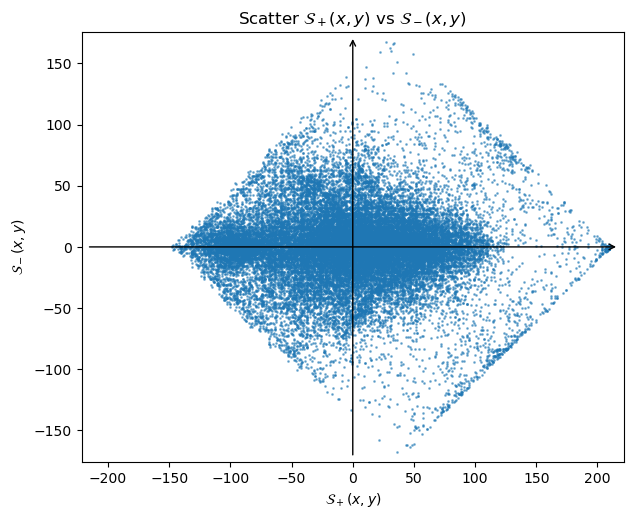

In [24]:
# Scatter plot of S+ vs S-
vals_plus = new_images[0].ravel()
vals_minus = new_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(vals_plus, vals_minus, alpha=0.5, s=1, rasterized=True)

plt.xlim(-max(vals_plus)*1.05, max(vals_plus)*1.05)
plt.ylim(-max(vals_minus)*1.05, max(vals_minus)*1.05)


plt.annotate('', xy=(max(vals_plus)*1.03, 0), xytext=(-max(vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(vals_minus)*1.03), xytext=(0, -max(vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$\\mathcal{S}_+(x,y)$')
plt.ylabel('$\\mathcal{S}_-(x,y)$')

plt.title('Scatter $\\mathcal{S}_+(x,y)$ vs $\\mathcal{S}_-(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_+-.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )

### O Gain control

$$\mathcal{O}_+(x,y) = g_+\mathcal{S}_+(x,y),\ \mathcal{O}_-(x,y) = g_-\mathcal{S}_-(x,y)$$
$$g_+ = \frac{1}{\sqrt{R^{\mathcal{S}}_{++}}},\ g_- = \frac{1}{\sqrt{R^{\mathcal{S}}_{--}}}$$

Gains for output images:
 [np.float64(0.017777504734981825), np.float64(0.033644712536654506)]


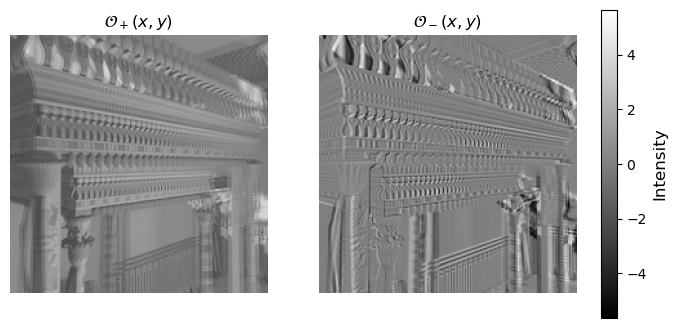

In [25]:
gains = [1/np.sqrt(new_cor_matrix[0,0]), 1/np.sqrt(new_cor_matrix[1,1])]
print("Gains for output images:\n", gains)
output_images = [gains[0]*new_images[0], gains[1]*new_images[1]]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(output_images[0])), np.max(np.abs(output_images[1]))])
im0 = axes[0].imshow(output_images[0], cmap='gray', vmin=-vmax, vmax=vmax)
im1 = axes[1].imshow(output_images[1], cmap='gray', vmin=-vmax, vmax=vmax)
axes[0].axis('off')
axes[0].set_title('$\\mathcal{O}_+(x,y)$')
axes[1].set_title('$\\mathcal{O}_-(x,y)$')
axes[1].axis('off')
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig(os.path.join(figures_dir, "images_Output_+-.pdf"),             
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )
plt.show()

### P Correlation matrix and Scatter of $\mathcal{O}_+$ and $\mathcal{O}_-$

In [26]:
# Compute correlation matrix for output images
output_cor_matrix = np.zeros((2, 2))
output_cor_matrix[0, 0] = compute_cor(output_images[0], output_images[0])
output_cor_matrix[1, 1] = compute_cor(output_images[1], output_images[1])
output_cor_matrix[0, 1] = compute_cor(output_images[0], output_images[1])
output_cor_matrix[1, 0] = output_cor_matrix[0, 1]
output_cor_matrix

array([[ 1.        , -0.02004197],
       [-0.02004197,  1.        ]])

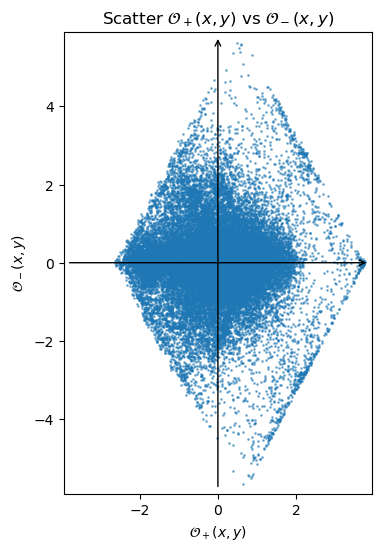

In [27]:
# Scatter plot of O+ vs O-
output_vals_plus = output_images[0].ravel()
output_vals_minus = output_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(output_vals_plus, output_vals_minus, alpha=0.5, s=1, rasterized=True)

plt.xlim(-max(output_vals_plus)*1.05, max(output_vals_plus)*1.05)
plt.ylim(-max(output_vals_minus)*1.05, max(output_vals_minus)*1.05)


plt.annotate('', xy=(max(output_vals_plus)*1.03, 0), xytext=(-max(output_vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(output_vals_minus)*1.03), xytext=(0, -max(output_vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$\\mathcal{O}_+(x,y)$')
plt.ylabel('$\\mathcal{O}_-(x,y)$')

plt.title('Scatter $\\mathcal{O}_+(x,y)$ vs $\\mathcal{O}_-(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_output_+-.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,      # 去掉额外留白
            )

### Q $O_1$, $O_2$ from $\mathcal{O}_+$ and $\mathcal{O}_-$, image and scatter

In [28]:
new_output_images = [(output_images[0] + output_images[1])/np.sqrt(2), (output_images[0] - output_images[1])/np.sqrt(2)]

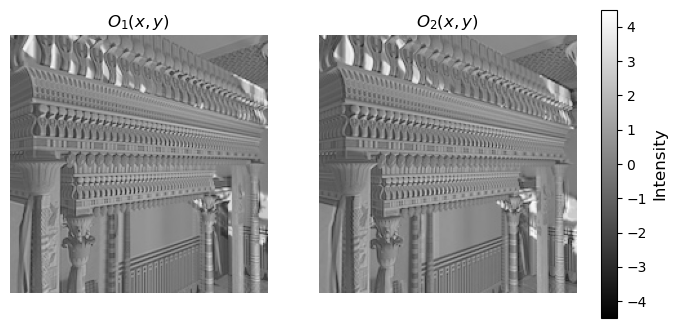

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(new_output_images[0])), np.max(np.abs(new_output_images[1]))])
im0 = axes[0].imshow(new_output_images[0], cmap='gray', vmin=-vmax, vmax=vmax)
im1 = axes[1].imshow(new_output_images[1], cmap='gray', vmin=-vmax, vmax=vmax)
axes[0].axis('off')
axes[0].set_title('$O_1(x,y)$')
axes[1].set_title('$O_2(x,y)$')
axes[1].axis('off')
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.savefig(os.path.join(figures_dir, "images_Output_12.pdf"),             
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )
plt.show()

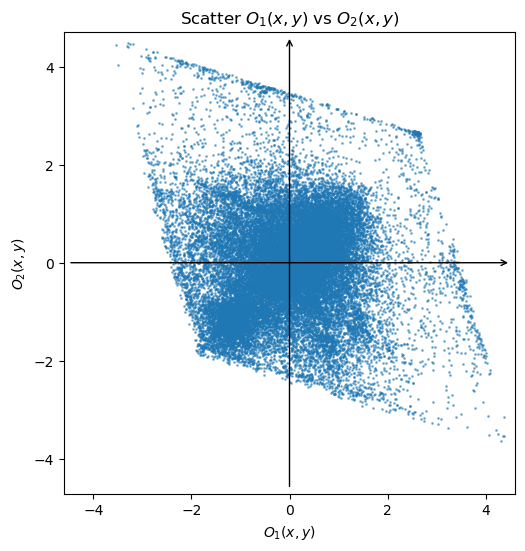

In [30]:
# Scatter plot of O1 vs O2
new_output_vals_plus = new_output_images[0].ravel()
new_output_vals_minus = new_output_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(new_output_vals_plus, new_output_vals_minus, alpha=0.5, s=1, rasterized=True)

plt.xlim(-max(new_output_vals_plus)*1.05, max(new_output_vals_plus)*1.05)
plt.ylim(-max(new_output_vals_minus)*1.05, max(new_output_vals_minus)*1.05)


plt.annotate('', xy=(max(new_output_vals_plus)*1.03, 0), xytext=(-max(new_output_vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(new_output_vals_minus)*1.03), xytext=(0, -max(new_output_vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$O_1(x,y)$')
plt.ylabel('$O_2(x,y)$')

plt.title('Scatter $O_1(x,y)$ vs $O_2(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_output_12.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,      # 去掉额外留白
            )

### R Correlation matrix of $O_1$ and $O_2$

In [31]:
# Compute correlation matrix for output images
new_output_cor_matrix = np.zeros((2, 2))
new_output_cor_matrix[0, 0] = compute_cor(new_output_images[0], new_output_images[0])
new_output_cor_matrix[1, 1] = compute_cor(new_output_images[1], new_output_images[1])
new_output_cor_matrix[0, 1] = compute_cor(new_output_images[0], new_output_images[1])
new_output_cor_matrix[1, 0] = new_output_cor_matrix[0, 1]
new_output_cor_matrix

array([[9.79958029e-01, 7.33159367e-16],
       [7.33159367e-16, 1.02004197e+00]])

---

### S Noise !!!

from A B and J

In [4]:
# noise amplitude
# N_max = np.sqrt((cor_matrix[0,0] + cor_matrix[1,1])/2)
N_max = np.sqrt((cor_matrix[0,0] + cor_matrix[1,1])/2)

# Add noises (int, if that's float, it would produce 200*200 unique values, too many for visluation)
noisy_images = [img + np.random.normal(-N_max, N_max, img.shape).astype(int) for img in images]
    
# normalize to [0, S_top]
for i, image in enumerate(noisy_images):
    max_val = np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val) * S_top
    image = image.astype(np.int16)
    noisy_images[i] = image  # Update the rescaled image


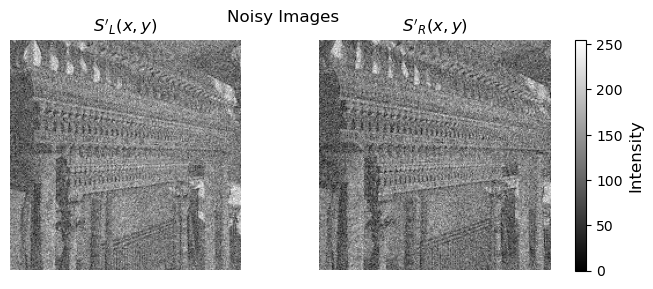

In [5]:
# Plot the noisy images
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # 一行两列
vmax = np.max([np.max(np.abs(noisy_images[0])), np.max(np.abs(noisy_images[1]))])
im0 = axes[0].imshow(noisy_images[0], cmap='gray', vmax=vmax)
im1 = axes[1].imshow(noisy_images[1], cmap='gray', vmax=vmax)
axes[0].axis('off')
axes[0].set_title('$S\'_L(x,y)$')
axes[1].set_title('$S\'_R(x,y)$')
axes[1].axis('off')
plt.suptitle('Noisy Images')
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(os.path.join(figures_dir, "images_noise_LR.pdf"),             
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

#### Repeat the above steps after adding noise to the original image

probability

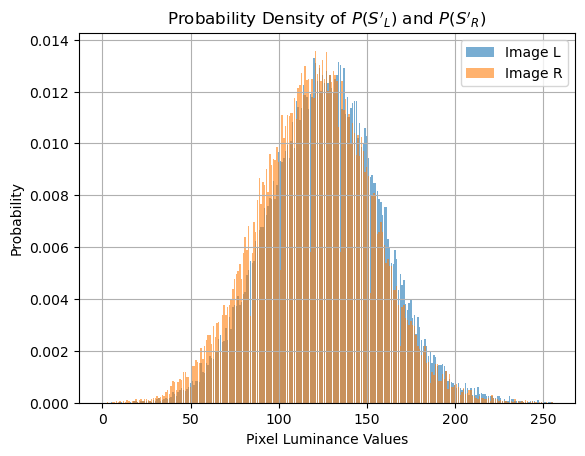

In [ ]:
noise_prob_values = []

for i ,image in enumerate(noisy_images):
    values, counts = np.unique(image, return_counts=True)
    sorted_indices = np.argsort(values)  # sorting by values
    values = values[sorted_indices]
    counts = counts[sorted_indices]
    # turn into probability distribution
    props = counts / np.sum(counts)
    noise_prob_values.append((values, props))
    plt.bar(values, props, label=f'Image {"L" if i==0 else "R"}', alpha=0.6)
plt.xlabel('Pixel Luminance Values')
plt.ylabel('Probability')
plt.title('Probability Density of $P(S\'_L)$ and $P(S\'_R)$')
plt.legend()
plt.grid()

# plt.savefig(os.path.join(figures_dir, "prob_noise_LR.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )

joint probability

Total probability (should be 1.0): 0.9999999999999999


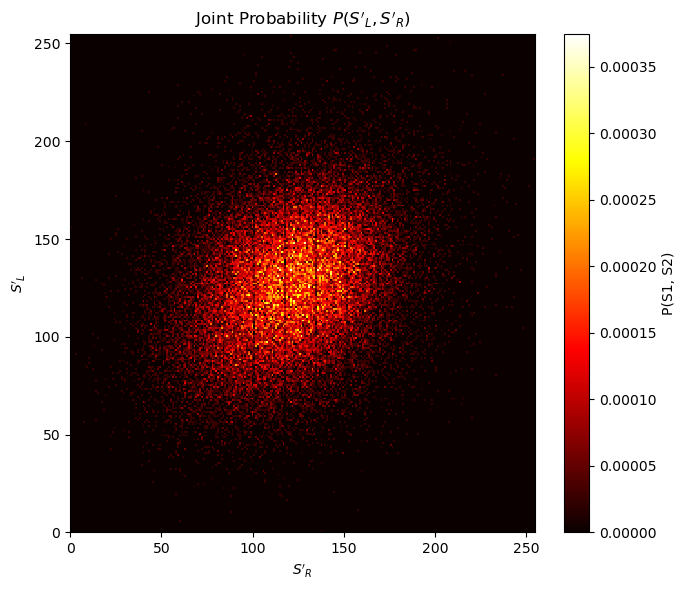

In [ ]:
# Compute true joint distribution P(S1, S2) from paired pixels (SL(x,y), SR(x,y))

noise_flatL = noisy_images[0].ravel()
noise_flatR = noisy_images[1].ravel()
noise_N = noise_flatL.size

S_max = np.max([np.max(noise_flatL), np.max(noise_flatR)])

noise_joint_counts = np.zeros((S_max + 1, S_max + 1), dtype=np.int64)
np.add.at(noise_joint_counts, (noise_flatL, noise_flatR), 1)  # accumulate counts for each (S1,S2)  AMAZING!!!

noise_joint_probs = noise_joint_counts / noise_N  # P(S1,S2) = n(S1,S2) / N

# quick sanity check
print("Total probability (should be 1.0):", noise_joint_probs.sum())

# Plot joint probability as a heatmap
plt.figure(figsize=(7, 6))
plt.imshow(noise_joint_probs, origin='lower', cmap='hot', 
           interpolation='nearest',
           extent=[0, S_max, 0, S_max], aspect='auto',
        #    vmin=-0.0001,
           vmax=noise_joint_probs.max())
# plt.ylim(0, S_max)
plt.colorbar(label='P(S1, S2)')
plt.xlabel('$S\'_R$')
plt.ylabel('$S\'_L$')
plt.title('Joint Probability $P(S\'_L, S\'_R)$')
plt.tight_layout()
# plt.savefig(os.path.join(figures_dir, f"joint_prob_noise_LR.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

Pixel Entropy, joint entropy, mutual information, redundancy

In [8]:
# entropy
noise_entropy_values = []
for i, image in enumerate(images):
    values, props = noise_prob_values[i]
    entropy = -np.sum(props * np.log2(props + 1e-10))  # add a small value to avoid log(0)
    noise_entropy_values.append(entropy)
    print(f'Entropy of noisy Image {"L" if i==0 else "R"}: {entropy:.4f} bits')

# joint entropy
noise_joint_entropy = np.sum(-noise_joint_probs * np.log2(noise_joint_probs + 1e-10)) # add a small value to avoid log(0)
print(f'Joint Entropy H(S\'_L, S\'_R): {noise_joint_entropy:.4f} bits')

# mutual information
noise_mutual_information = noise_entropy_values[0] + noise_entropy_values[1] - noise_joint_entropy
print(f'Mutual Information I(S\'_L; S\'_R): {noise_mutual_information:.4f} bits')

# redundancy
noise_redundancy = (noise_entropy_values[0] + noise_entropy_values[1]) / noise_joint_entropy - 1
print(f'Redundancy R: {noise_redundancy:.4f} bits') 


Entropy of noisy Image L: 7.0313 bits
Entropy of noisy Image R: 7.0484 bits
Joint Entropy H(S'_L, S'_R): 13.4926 bits
Mutual Information I(S'_L; S'_R): 0.5870 bits
Redundancy R: 0.0435 bits


$S'_L$ and $S'_R$: Correlation matrix, scatter, eigenvalues and eigenvectors, scatter with eigenvetors

Noisy correlation matrix:
 [[ 985.290375  288.618125]
 [ 288.618125 1027.186075]]
Noisy Eigenvalues:
 [ 716.86090298 1295.61554702]
Noisy Eigenvectors:
 [[-0.73225317 -0.68103253]
 [ 0.68103253 -0.73225317]]


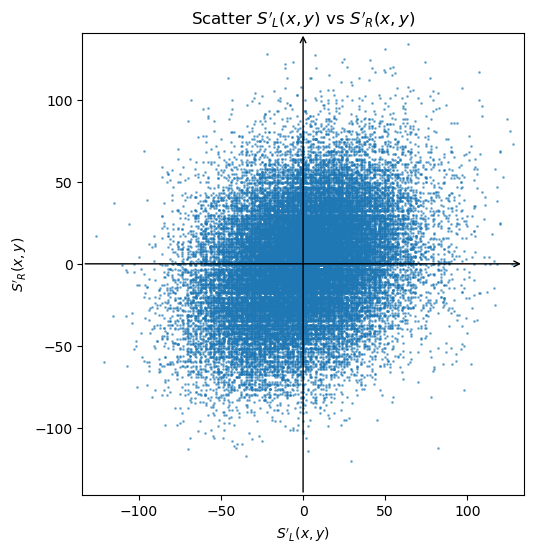

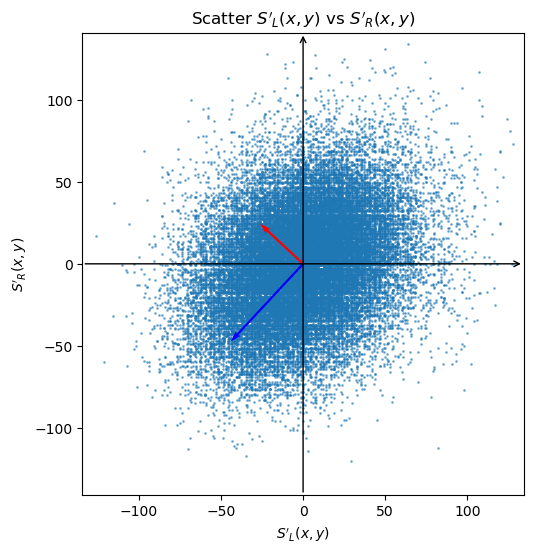

In [9]:
# shift to zero-mean
zero_mean_noisy_images = np.array([img - np.mean(img) for img in noisy_images]).astype(np.int32)

# correlation matrix
noise_cor_matrix = np.zeros((2, 2))
noise_cor_matrix[0, 0] = compute_cor(zero_mean_noisy_images[0], zero_mean_noisy_images[0])
noise_cor_matrix[1, 1] = compute_cor(zero_mean_noisy_images[1], zero_mean_noisy_images[1])
noise_cor_matrix[0, 1] = compute_cor(zero_mean_noisy_images[0], zero_mean_noisy_images[1])
noise_cor_matrix[1, 0] = noise_cor_matrix[0, 1]

print("Noisy correlation matrix:\n", noise_cor_matrix)


# scatter plot
noise_vals_L = zero_mean_noisy_images[0].ravel()
noise_vals_R = zero_mean_noisy_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(noise_vals_L, noise_vals_R, alpha=0.5, s=1, rasterized=True)
plt.xlabel('$S\'_L(x,y)$')
plt.ylabel('$S\'_R(x,y)$')
plt.xlim(-max(noise_vals_L)*1.05, max(noise_vals_L)*1.05)
plt.ylim(-max(noise_vals_R)*1.05, max(noise_vals_R)*1.05)

plt.annotate('', xy=(max(noise_vals_L)*1.05, 0), xytext=(-max(noise_vals_L)*1.05, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(noise_vals_R)*1.05), xytext=(0, -max(noise_vals_R)*1.05),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.title('Scatter $S\'_L(x,y)$ vs $S\'_R(x,y)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(figures_dir, f"scatter_noise_LR.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )


# eigenvalues and eigenvectors

noise_eigen_vals, noise_eigen_vecs = np.linalg.eig(noise_cor_matrix)
# w: (1-D) array of eigenvalue
# v: (2-D) array of eigenvalue vector
print("Noisy Eigenvalues:\n", noise_eigen_vals)
print("Noisy Eigenvectors:\n", noise_eigen_vecs)


# plot the scatter with eigenvectors

plt.figure(figsize=(7, 6))
plt.scatter(noise_vals_L, noise_vals_R, alpha=0.5, s=1, rasterized=True)
plt.xlabel('$S\'_L(x,y)$')
plt.ylabel('$S\'_R(x,y)$')
plt.xlim(-max(noise_vals_L)*1.05, max(noise_vals_L)*1.05)
plt.ylim(-max(noise_vals_R)*1.05, max(noise_vals_R)*1.05)

plt.annotate('', xy=(max(noise_vals_L)*1.05, 0), xytext=(-max(noise_vals_L)*1.05, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(noise_vals_R)*1.05), xytext=(0, -max(noise_vals_R)*1.05),
             arrowprops=dict(arrowstyle='->', color='k'))

ox, oy = np.zeros(2), np.zeros(2)  # two arrow start positions at the origin
scale = noise_eigen_vals /20
U = noise_eigen_vecs[0, :] * scale
V = noise_eigen_vecs[1, :] * scale
plt.quiver(ox, oy, U, V, angles='xy', scale_units='xy', scale=1, color=['r', 'b'], width=0.005)


plt.title('Scatter $S\'_L(x,y)$ vs $S\'_R(x,y)$')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(os.path.join(figures_dir, f"scatter_noise_LR_with_eigenvectors.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )

$\mathcal{S}'_+$ and $\mathcal{S}'_-$: images, correlation matrix, scatter plot

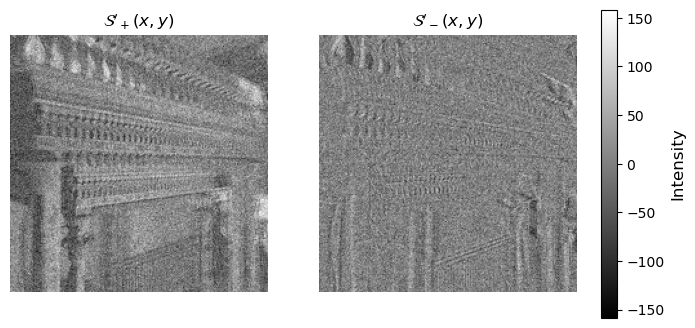

[[1294.85635   20.94785]
 [  20.94785  717.6201 ]]


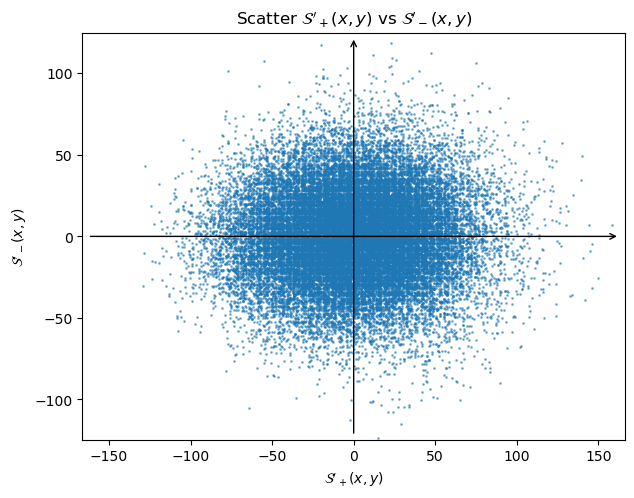

In [10]:
# Note that here we use the zero-mean images
noise_image_plus = (zero_mean_noisy_images[0] + zero_mean_noisy_images[1])/np.sqrt(2)
noise_image_minus = (-zero_mean_noisy_images[0] + zero_mean_noisy_images[1])/np.sqrt(2)
noisy_new_images = [noise_image_plus, noise_image_minus]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(noisy_new_images[0])), np.max(np.abs(noisy_new_images[1]))])
im0 = axes[0].imshow(noisy_new_images[0], cmap='gray', vmax=vmax, vmin=-vmax)
im1 = axes[1].imshow(noisy_new_images[1], cmap='gray', vmax=vmax, vmin=-vmax)
axes[0].axis('off')
axes[0].set_title('$\\mathcal{S}\'_+(x,y)$')
axes[1].set_title('$\\mathcal{S}\'_-(x,y)$')
axes[1].axis('off')

cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(os.path.join(figures_dir, "images_noise_+-.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

# Compute correlation matrix for new images
noise_new_cor_matrix = np.zeros((2, 2))
noise_new_cor_matrix[0, 0] = compute_cor(noisy_new_images[0], noisy_new_images[0])
noise_new_cor_matrix[1, 1] = compute_cor(noisy_new_images[1], noisy_new_images[1])
noise_new_cor_matrix[0, 1] = compute_cor(noisy_new_images[0], noisy_new_images[1])
noise_new_cor_matrix[1, 0] = noise_new_cor_matrix[0, 1]
print(noise_new_cor_matrix)


# plot the scatter

# Scatter plot of S+ vs S-
noise_vals_plus = noisy_new_images[0].ravel()
noise_vals_minus = noisy_new_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(noise_vals_plus, noise_vals_minus, alpha=0.5, s=1, rasterized=True)

plt.xlim(-max(noise_vals_plus)*1.05, max(noise_vals_plus)*1.05)
plt.ylim(-max(noise_vals_minus)*1.05, max(noise_vals_minus)*1.05)


plt.annotate('', xy=(max(noise_vals_plus)*1.03, 0), xytext=(-max(noise_vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(noise_vals_minus)*1.03), xytext=(0, -max(noise_vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$\\mathcal{S}\'_+(x,y)$')
plt.ylabel('$\\mathcal{S}\'_-(x,y)$')

plt.title('Scatter $\\mathcal{S}\'_+(x,y)$ vs $\\mathcal{S}\'_-(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_noise_+-.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,         # 去掉额外留白
            )


gain control $\mathcal{O}'_-$ and $\mathcal{O}'_+$: images, correlation matrix and scatter

Gains for noisy images:
 [np.float64(0.02779004208959248), np.float64(0.03732954554222337)]
[[1.         0.02173108]
 [0.02173108 1.        ]]


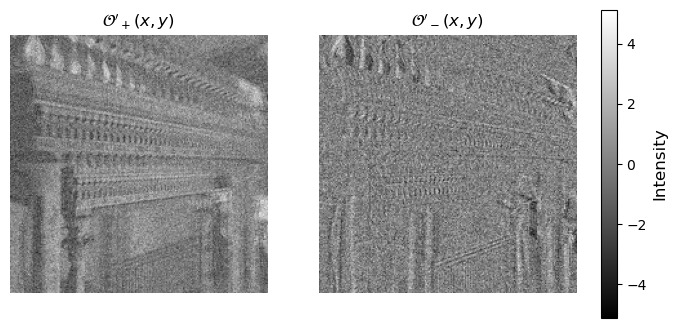

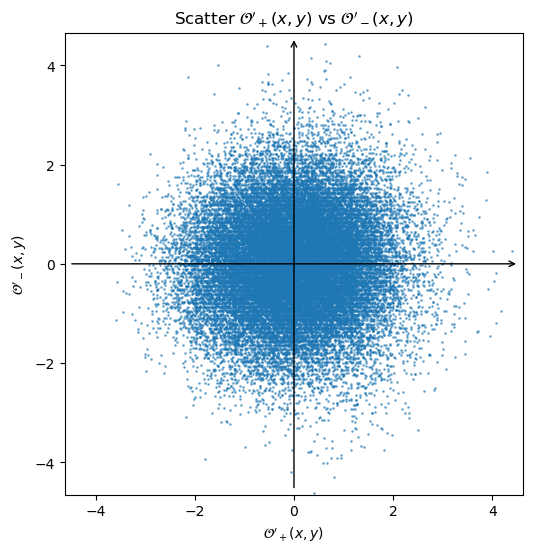

In [11]:
gains_noise = [1/np.sqrt(noise_new_cor_matrix[0,0]), 1/np.sqrt(noise_new_cor_matrix[1,1])]

print("Gains for noisy images:\n", gains_noise)

noise_output_images = [gains_noise[0]*noisy_new_images[0], gains_noise[1]*noisy_new_images[1]]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(noise_output_images[0])), np.max(np.abs(noise_output_images[1]))])
im0 = axes[0].imshow(noise_output_images[0], cmap='gray', vmin=-vmax, vmax=vmax)
im1 = axes[1].imshow(noise_output_images[1], cmap='gray', vmin=-vmax, vmax=vmax)
axes[0].axis('off')
axes[0].set_title('$\\mathcal{O}\'_+(x,y)$')
axes[1].set_title('$\\mathcal{O}\'_-(x,y)$')
axes[1].axis('off')
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(os.path.join(figures_dir, "images_Output_noise_+-.pdf"),             
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )

# correlation matrix for output noisy images

noise_output_cor_matrix = np.zeros((2, 2))
noise_output_cor_matrix[0, 0] = compute_cor(noise_output_images[0], noise_output_images[0])
noise_output_cor_matrix[1, 1] = compute_cor(noise_output_images[1], noise_output_images[1])
noise_output_cor_matrix[0, 1] = compute_cor(noise_output_images[0], noise_output_images[1])
noise_output_cor_matrix[1, 0] = noise_output_cor_matrix[0, 1]
print(noise_output_cor_matrix)

# Scatter plot of O'+ vs O'-
noise_output_vals_plus = noise_output_images[0].ravel()
noise_output_vals_minus = noise_output_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(noise_output_vals_plus, noise_output_vals_minus, alpha=0.5, s=1, rasterized=True)

plt.xlim(-max(noise_output_vals_plus)*1.05, max(noise_output_vals_plus)*1.05)
plt.ylim(-max(noise_output_vals_minus)*1.05, max(noise_output_vals_minus)*1.05)


plt.annotate('', xy=(max(noise_output_vals_plus)*1.03, 0), xytext=(-max(noise_output_vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(noise_output_vals_minus)*1.03), xytext=(0, -max(noise_output_vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$\\mathcal{O}\'_+(x,y)$')
plt.ylabel('$\\mathcal{O}\'_-(x,y)$')

plt.title('Scatter $\\mathcal{O}\'_+(x,y)$ vs $\\mathcal{O}\'_-(x,y)$')

plt.savefig(os.path.join(figures_dir, f"scatter_output_noise_+-.pdf"),
            bbox_inches='tight',  # 紧贴内容裁剪
            pad_inches=0.1,      # 去掉额外留白
            )

Output $O'_1$ and $O'_2$: images, correlation matrices, and scatter plots

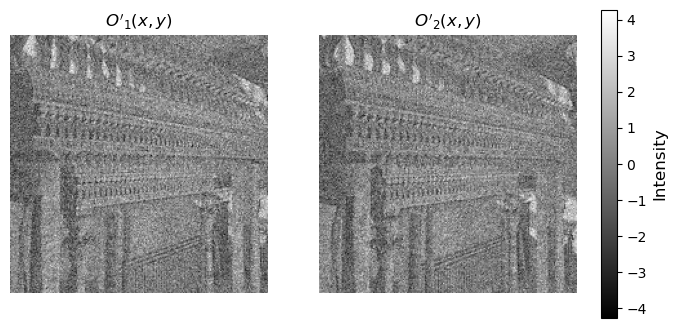

[[ 1.02173108e+00 -4.63061013e-17]
 [-4.63061013e-17  9.78268917e-01]]


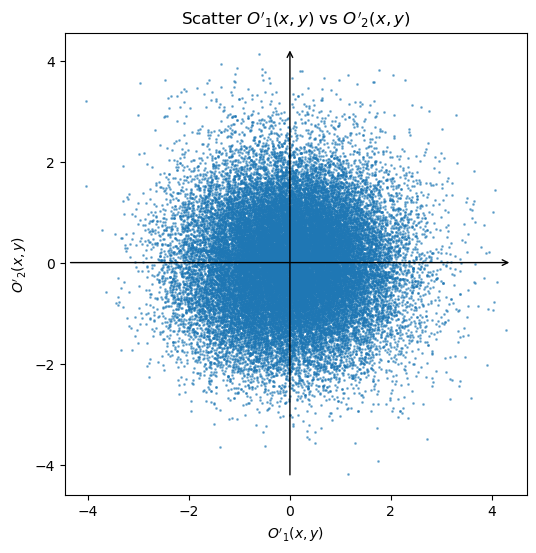

In [ ]:
noise_new_output_images = [(noise_output_images[0] + noise_output_images[1])/np.sqrt(2), (noise_output_images[0] - noise_output_images[1])/np.sqrt(2)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 一行两列

vmax = np.max([np.max(np.abs(noise_new_output_images[0])), np.max(np.abs(noise_new_output_images[1]))])
im0 = axes[0].imshow(noise_new_output_images[0], cmap='gray', vmin=-vmax, vmax=vmax)
im1 = axes[1].imshow(noise_new_output_images[1], cmap='gray', vmin=-vmax, vmax=vmax)
axes[0].axis('off')
axes[0].set_title('$O\'_1(x,y)$')
axes[1].set_title('$O\'_2(x,y)$')
axes[1].axis('off')
cbar = fig.colorbar(im0, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
cbar.set_label('Intensity', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# plt.savefig(os.path.join(figures_dir, "images_Output_noise_12.pdf"),             
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,         # 去掉额外留白
#             )
plt.show()

# Compute correlation matrix for output noisy images
noise_new_output_cor_matrix = np.zeros((2, 2))
noise_new_output_cor_matrix[0, 0] = compute_cor(noise_new_output_images[0], noise_new_output_images[0])
noise_new_output_cor_matrix[1, 1] = compute_cor(noise_new_output_images[1], noise_new_output_images[1])
noise_new_output_cor_matrix[0, 1] = compute_cor(noise_new_output_images[0], noise_new_output_images[1])
noise_new_output_cor_matrix[1, 0] = noise_new_output_cor_matrix[0, 1]
print(noise_new_output_cor_matrix)

# Scatter plot of O'1 vs O'2
noise_new_output_vals_plus = noise_new_output_images[0].ravel()
noise_new_output_vals_minus = noise_new_output_images[1].ravel()
plt.figure(figsize=(7, 6))
plt.scatter(noise_new_output_vals_plus, noise_new_output_vals_minus, alpha=0.5, s=1, rasterized=True)

plt.annotate('', xy=(max(noise_new_output_vals_plus)*1.03, 0), xytext=(-max(noise_new_output_vals_plus)*1.03, 0),
             arrowprops=dict(arrowstyle='->', color='k'))
plt.annotate('', xy=(0, max(noise_new_output_vals_minus)*1.03), xytext=(0, -max(noise_new_output_vals_minus)*1.03),
             arrowprops=dict(arrowstyle='->', color='k'))

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('$O\'_1(x,y)$')
plt.ylabel('$O\'_2(x,y)$')

plt.title('Scatter $O\'_1(x,y)$ vs $O\'_2(x,y)$')

# plt.savefig(os.path.join(figures_dir, f"scatter_output_noise_12.pdf"),
#             bbox_inches='tight',  # 紧贴内容裁剪
#             pad_inches=0.1,      # 去掉额外留白
#             )